In [1]:
'''
Python implementation example of t-METASET for 2D orthotropic mechanical mechanical dataset
Scenario: Prioritizing samples with high anisotropy (Task II-2 in Lee et al., 2023, JMD)
'''

import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pdb
import time
import torch

import gpytorch
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
import os
from tqdm import tqdm
import scipy.io as sio
from sklearn.metrics import mean_squared_error

#from GP_gpytorch import GP # as GP
#from util import *
from DPP import *
#import gpflow as gpf
import itertools
import traceback
plt.rcParams.update({'font.size': 10})

In [2]:
'''
Loading helper functions, data, and preprocessing
'''
from utils import standardize, pairwise_scatter_half_triangle_plot, RMSE, preference
# Shape Descriptor: VAE latent representation (precomputed)
descriptor = loadmat('./data/Wang_CMAME_2020/latent.mat')['X_latent'] # 10-D VAE desriptor
# property precomputed for quick experiment
Prop = loadmat('./data/Wang_CMAME_2020/EDataBase_90k.mat')['EDataBase'][:, :3] # property 
# img = loadmat('./data/Wang_CMAME_2020/PhiDataBase_90k.mat')['PhiDataBase'].transpose([2, 0, 1])

descriptor = standardize(descriptor)
prop =  standardize(Prop)

print(descriptor.shape, Prop.shape) # sanity check

(88180, 10) (88180, 3)


In [7]:
'''
Learning class of the learner (GP through gpytorch)
'''
from GP_gpytorch import GP

In [16]:
'''
t-metaset class
'''
class t_METASET:
    def __init__(self, descriptor, n_batch_max, D_prop, prop_precomputed=None,
                 batch_size=10, prop_batch_ratio=0.8, flag_prop_bias=True, flag_active_plot=True, 
                 exponent_descriptor=6, exponent_prop=6, D_feature=2000,
                 prop_bias_type='aniso', prop_transf_type='sigmoid',
                 roughness_tolerance=0.2, roughness_iter_tolerance=5,
                 np_seed=None):
        self.n_batch_max = n_batch_max        
        self.descriptor = descriptor
        self.prop_precomputed = prop_precomputed
        self.D_prop = D_prop                        
        self.batch_size = batch_size
        self.exponent_descriptor = exponent_descriptor
        self.exponent_prop = exponent_prop
        self.D_feature = D_feature
        self.flag_prop_bias = flag_prop_bias
        self.prop_bias_type = prop_bias_type
        self.prop_transf_type = prop_transf_type
        self.prop_batch_ratio = prop_batch_ratio
        self.roughness_tolerance = roughness_tolerance
        self.roughness_iter_tolerance = roughness_iter_tolerance
        self.flag_active_plot = flag_active_plot
        self.n_sample_max = self.n_batch_max * self.batch_size

        # Initialization        
        self.iter_in = 0        
        if np_seed is not None:
            np.random.seed(np_seed)
        self.n_data, D_descriptor = self.descriptor.shape
        self.is_model_converged = False
        self.roughness_converged_iter = 0
        self.convergence_cnt = 0        
        self.iter_roughness_converged = []
        self.iter_roughness_converged_2nd = []
        self.roughness = []
        self.roughness_residue = []
        self.descriptor_mean_dists = []
        self.prop_mean_dists = []
        self.index_left = np.array(range(self.n_data))
        self.feature_descriptor = RFF(self.descriptor, self.D_feature)
        self.time_iteration = []
        self.index_dpp = []
        self.index_dpp_list_order_preserved = []
    
    def evaluate(self): ## in case where you wish to include design evaluation
        pass

    def step(self):
        iter_in = self.iter_in  # Retrieve iter_in from the attribute
        start_iter = time.time()
        
        ##### DPP #####
        if iter_in == 0:
            # Markov DPP for the first iter
            index_dpp_new_rel, index_dpp_new_abs, L_descriptor_tmp = k_Markov_dual_DPP(self.feature_descriptor,
                                                                                         self.index_left,
                                                                                         batch_size=2 * self.batch_size,
                                                                                         exponent=self.exponent_descriptor)
            index_dpp_new_rel = index_dpp_new_rel[::2]
            index_dpp_new_abs = self.index_left[index_dpp_new_rel]
            self.index_left = np.setdiff1d(self.index_left, index_dpp_new_abs) 
            self.feature_descriptor = Markov_update_RFF(self.feature_descriptor, index_dpp_new_rel, self.exponent_descriptor)
                            
        elif (iter_in >= 1) * (not self.is_model_converged):
            index_dpp_new_rel, index_dpp_new_abs, L_descriptor_tmp = k_Markov_dual_DPP(self.feature_descriptor,
                                                                                         self.index_left,
                                                                                         self.batch_size,
                                                                                         self.exponent_descriptor)
            self.index_left = np.setdiff1d(self.index_left, index_dpp_new_abs) 
            self.feature_descriptor = Markov_update_RFF(self.feature_descriptor, index_dpp_new_rel, self.exponent_descriptor)
        else:
            if self.prop_batch_ratio == 0:  # only-shape-diversity sampling
                index_dpp_new_rel, index_dpp_new_abs, L_descriptor_tmp = k_Markov_dual_DPP(self.feature_descriptor,
                                                                                                 self.index_left,
                                                                                                 self.batch_size,
                                                                                                 self.exponent_descriptor)
                self.index_left = np.setdiff1d(self.index_left, index_dpp_new_abs) 
                self.feature_descriptor = Markov_update_RFF(self.feature_descriptor, index_dpp_new_rel, self.exponent_descriptor)
            else: 
                index_dpp_new_rel1, index_dpp_new_abs1, L_prop_tmp = k_Markov_dual_DPP(self.feature_prop,
                                                                                         self.index_left,
                                                                                         batch_size=int(np.ceil(self.batch_size * self.prop_batch_ratio)),
                                                                                         exponent=self.exponent_prop)
                index_left1 = np.setdiff1d(self.index_left, index_dpp_new_abs1) 
                self.feature_descriptor = Markov_update_RFF(self.feature_descriptor, index_dpp_new_rel1, self.exponent_descriptor)
                index_dpp_new_rel2, index_dpp_new_abs2, L_descriptor_tmp = k_Markov_dual_DPP(self.feature_descriptor,
                                                                                                 index_left1,
                                                                                                 batch_size=int(self.batch_size - np.ceil(self.batch_size * self.prop_batch_ratio)),
                                                                                                 exponent=self.exponent_descriptor)
                index_dpp_new_abs = np.union1d(index_dpp_new_abs1, index_dpp_new_abs2) 
                self.index_left = np.setdiff1d(index_left1, index_dpp_new_abs)
                self.feature_descriptor = Markov_update_RFF(self.feature_descriptor, index_dpp_new_rel2, self.exponent_descriptor)
                
        self.index_dpp_list_order_preserved.append(index_dpp_new_abs)    
        self.index_dpp = np.union1d(self.index_dpp, index_dpp_new_abs).astype('int')       
        
        ##### Evaluation (labeling) (e.g., FEM) #####
        # in this experiment, the data has been fully evaluated, thus we simply select the corresponding properties
        if self.prop_precomputed is not None: # if precomputed prop has been given
            self.prop_dpp_raw = self.prop_precomputed[self.index_dpp]
            self.prop_dpp_normalized = (self.prop_dpp_raw - self.prop_dpp_raw.min(0)) / \
             (self.prop_dpp_raw.max(0)  - self.prop_dpp_raw.min(0))
        else: # should be be replaced with evaluation w.r.t. the new samples
            pass
            # properties = self.evalute()    
            # self.prop_dpp_normalized = (properties - properties.min(0)) / (properties.max(0) - properties.min(0) )
            
        ##### Leaner update (e.g., GP regressor) #####    
        self.learner = GP(torch.FloatTensor(self.descriptor[self.index_dpp]), torch.FloatTensor(self.prop_dpp_normalized)) # #$%     
        self.learner.train_model()
        self.prop_pred = self.learner.pred(torch.FloatTensor(self.descriptor))    # predict
        if self.is_model_converged:          
            self.prop_pred_standardized = standardize(self.prop_pred)
            self.feature_prop = RFF(self.prop_pred_standardized, self.D_feature) # building random Fourier feature (RFF) of property feature                    
            if self.flag_prop_bias: # considering preference
                self.pointwise_quality_score, _ = preference(np.clip(self.prop_pred, 0, 1),                                               
                                                          transf_type=self.prop_transf_type,
                                                          bias_type=self.prop_bias_type)   
                self.feature_prop *= np.tile(self.pointwise_quality_score, [self.D_feature,1]) #
            self.feature_prop = Markov_update_RFF(self.feature_prop, self.index_dpp, self.exponent_prop) # conditioning on the observed
    
        ##### Roughness monitor #####    
        self.roughness.append(self.learner.roughness())    
        if not iter_in == 0:
            self.roughness_residue.append(RMSE(self.roughness[-1], self.roughness[-2])) 
        if iter_in >= self.roughness_iter_tolerance + 1:  
            if not self.is_model_converged:
                if len(self.roughness_residue) >= self.roughness_iter_tolerance:
                    if all(residue <= self.roughness_tolerance for residue in self.roughness_residue[-self.roughness_iter_tolerance:]):
                        self.is_model_converged = 1
                        self.roughness_converged_iter = iter_in                
                        print('1st roughness convergence has occured.')
                        # random Fourier feature (RFF) of property update
                        self.prop_pred_standardized = standardize(self.prop_pred)
                        self.feature_prop = RFF(self.prop_pred_standardized, self.D_feature) # firstly building random Fourier feature (RFF) of property                    
                        if self.flag_prop_bias: # considering preference
                            self.pointwise_quality_score, _ = preference(np.clip(self.prop_pred, 0, 1),                                             
                                                                      transf_type=self.prop_transf_type,
                                                                      bias_type=self.prop_bias_type)   
                            self.feature_prop *= np.tile(self.pointwise_quality_score, [self.D_feature,1]) # self.pointwise_quality_score.unsqueeze(-1)#[:, np.newaxis]
                        self.feature_prop = Markov_update_RFF(self.feature_prop, self.index_dpp, self.exponent_prop)         

        ##### Active plots for monitor #####
        self.descriptor_mean_dists.append(np.mean(pdist(self.descriptor[self.index_dpp])))
        self.prop_mean_dists.append(np.mean(pdist(self.prop_dpp_raw)))
#        self.prop_mean_dists.append(np.mean(pdist(self.prop_dpp_normalized)))        
        
        if self.flag_active_plot:
            # Metrics     
            if iter_in >= 2:
                fig, ax = plt.subplots(1,3, figsize=(10, 3))
                clear_output(wait=True)
                ax[0].plot(self.roughness_residue[:iter_in])   
                ax[0].set_title('roughness_residual')
                ax[1].plot(range(iter_in+1), self.descriptor_mean_dists)
                ax[1].set_title('mean descriptor distance')
                ax[1].set_xlabel('(standardized)')                
                ax[2].plot(range(iter_in+1), self.prop_mean_dists)
                ax[2].set_title('mean prop distance')        
                ax[2].set_xlabel('(raw scale)')                
                if self.roughness_converged_iter != 0:
                    ax[0].axvline(x=self.roughness_converged_iter-1, linestyle='--', color='k')            
                    ax[1].axvline(x=self.roughness_converged_iter, linestyle='--', color='k')                        
                    ax[2].axvline(x=self.roughness_converged_iter, linestyle='--', color='k')                                            
                plt.pause(0.01)
                plt.show()    

                pairwise_scatter_half_triangle_plot(self.prop_dpp_raw, self.batch_size)
#                pairwise_scatter_half_triangle_plot(self.prop_dpp_normalized, self.batch_size)                

        end_iter = time.time()
        self.time_iteration.append(np.round(end_iter - start_iter, 1))
        print(str(np.round(end_iter - start_iter, 1)) + " sec took at iter=", str(iter_in))
        
        self.iter_in += 1

In [17]:
'''
t-metaset instantiation & intialization
'''
t_metaset = t_METASET(descriptor=descriptor, 
                                n_batch_max=200, 
                                D_prop=3, 
                                prop_precomputed=Prop,
                                batch_size=10, 
                                prop_batch_ratio=0.8, 
                                flag_prop_bias=True, 
                                prop_bias_type='aniso', 
                                prop_transf_type='sigmoid',                      
                                D_feature=500, # 2000
                                flag_active_plot=True,                       
                                np_seed=42)

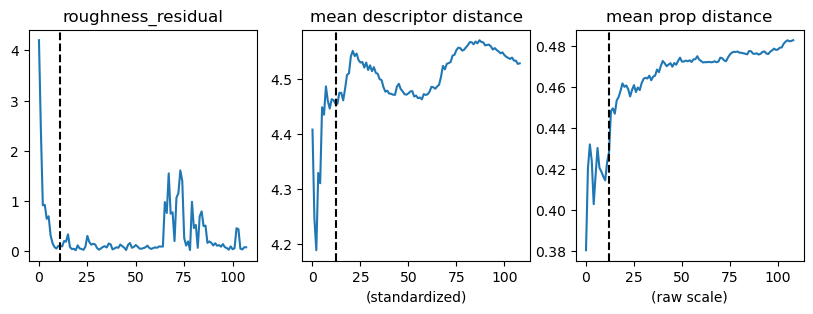

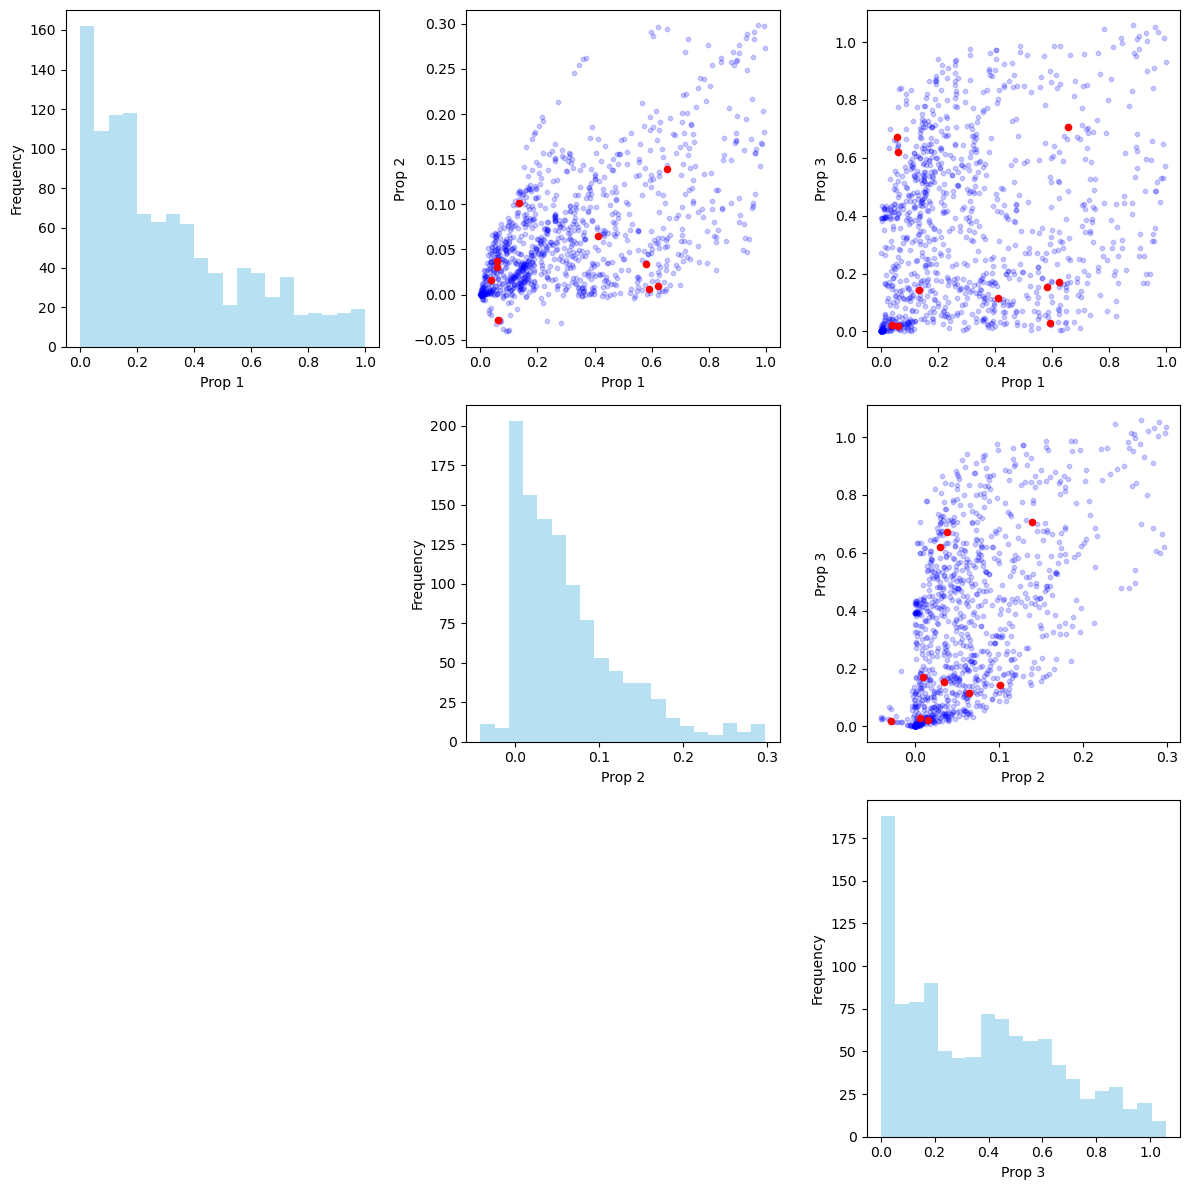

62.3 sec took at iter= 108


In [ ]:
'''
main loop
'''
# Run the step method
for iter in range(t_metaset.n_batch_max):
    t_metaset.step()